In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## __Preparación de los datos__



In [2]:
durl_file_path = 'https://raw.githubusercontent.com/LuisAngel021/Parciales_HPC2022/main/advertising_china.csv'
data = pd.read_csv(durl_file_path)

In [3]:
data

,wechat,weibo,others,sales
0,304.4,93.6,294.4,9.7
1,1011.9,34.4,398.4,16.7
2,1091.1,32.8,295.2,17.3
3,85.5,173.6,403.2,7.0
4,1047.0,302.4,553.6,22.1
...,...,...,...,...
195,869.5,229.6,145.6,17.3
196,1195.3,230.4,127.2,20.2
197,121.9,264.0,154.4,8.8
198,343.5,86.4,48.0,11.9


In [5]:
data.sales = data.sales.map(lambda x: str(x).replace(',','.')).astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wechat  200 non-null    float64
 1   weibo   200 non-null    float64
 2   others  200 non-null    float64
 3   sales   200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB



Se genera el conjutno de pruebas (del 20%)

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=3, shuffle=True)

In [7]:
train.isnull().sum()

wechat    0
weibo     0
others    0
sales     0
dtype: int64

In [8]:
from sklearn.impute import SimpleImputer

simple_imputer = SimpleImputer(strategy="mean")

In [9]:
from sklearn.preprocessing import StandardScaler

standar_scaler = StandardScaler()

In [10]:
from sklearn.pipeline import Pipeline

preprocessor = Pipeline(
    steps=[("numerical_imputer", simple_imputer), 
           ("scaler", standar_scaler)])

In [11]:
transformed_train = preprocessor.fit_transform(train[['wechat', 'weibo', 'others']])
transformed_train = pd.DataFrame(transformed_train, columns=['wechat', 'weibo', 'others'], index=train.index)
transformed_train['sales'] = train['sales']
transformed_train.head()

,wechat,weibo,others,sales
156,0.905192,-1.304991,-0.768701,16.5
115,1.415755,-0.199779,-1.348469,17.4
155,-1.058633,-1.151859,-0.016816,8.7
15,-0.351999,-1.018701,-0.315758,11.0
61,0.754048,-0.159831,-0.877408,20.9


Comentario: 
* Se construye un pipeline que incluyre los valores faltantes y el proceso de escalado


## Análisis exploratorio


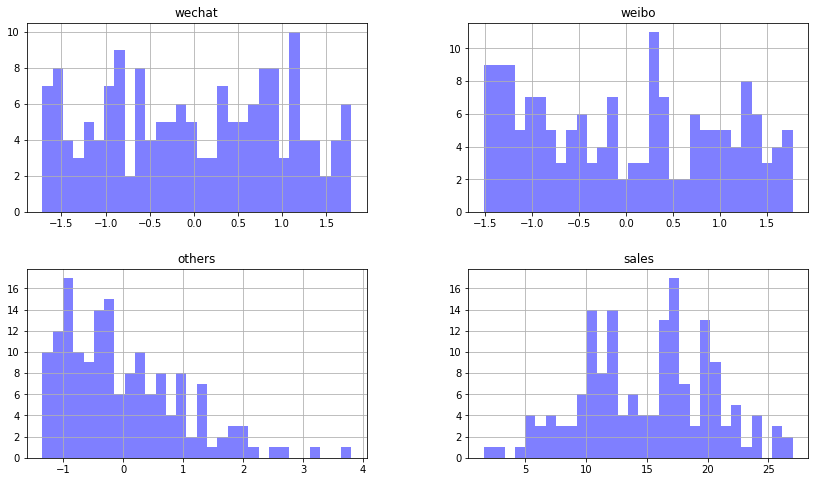

In [12]:
transformed_train.hist(bins=30, figsize=(14,8), color="blue", alpha=0.5) 
plt.show()

Comentario: 
* Se genera un histograma de frecuencias para cada variable disponible

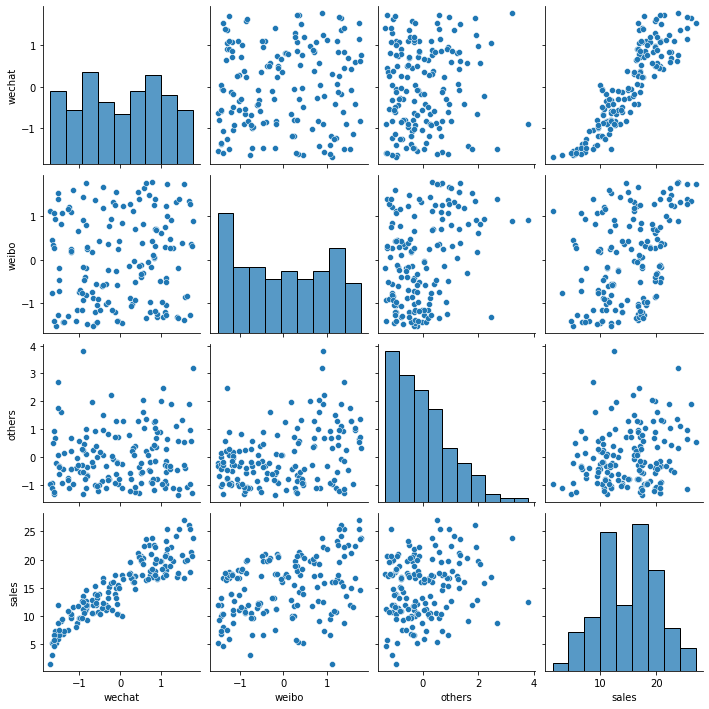

In [13]:
from seaborn.distributions import kdeplot
import seaborn as sns
sns.pairplot(transformed_train)

Comentario:

* Se genera una matriz de correlación para todas las variables, de esta forma se analizara que variable tiene más relación con la predicción. Esto se visualizara en un mapa de calor.

In [14]:
transformed_train.corr()

,wechat,weibo,others,sales
wechat,1.000000,0.078110,0.085561,0.897646
weibo,0.078110,1.000000,0.348048,0.377389
others,0.085561,0.348048,1.000000,0.195780
sales,0.897646,0.377389,0.195780,1.000000


In [15]:
transformed_train.corr()['sales'].sort_values(ascending=False)

sales     1.000000
wechat    0.897646
weibo     0.377389
others    0.195780
Name: sales, dtype: float64

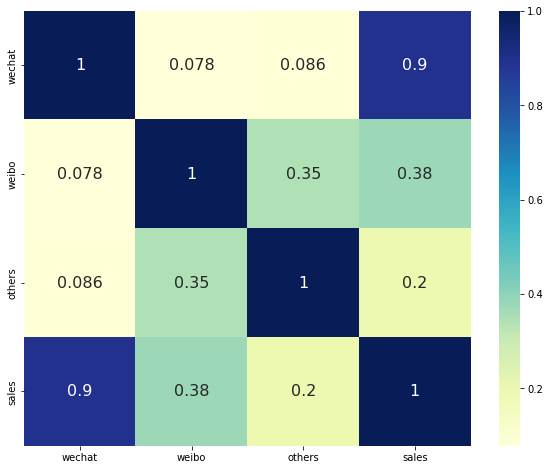

In [16]:
plt.figure(figsize=(10, 8))
plt.rc({'size': '18'})
sns.heatmap(transformed_train.corr(), annot=True, cmap="YlGnBu", annot_kws={"size":16})

Comentario: 
* Se concluye que la red social Wechat tiene más relación con la variable a predecir.

## Generación del modelo

In [17]:
from sklearn.linear_model import SGDRegressor

model_result = {}
X_train, y_train = train.drop('sales', axis='columns'), train['sales']

In [18]:
for feature in X_train.columns:
  
  regressorSGD = Pipeline(
      steps=[("numerical_imputer", SimpleImputer(strategy='mean')), 
           ("scaler", StandardScaler()), 
           ("sgd", SGDRegressor())])
  
  regressorSGD.fit(X_train[feature].values.reshape(-1,1), y_train)

  model_result[feature] = regressorSGD

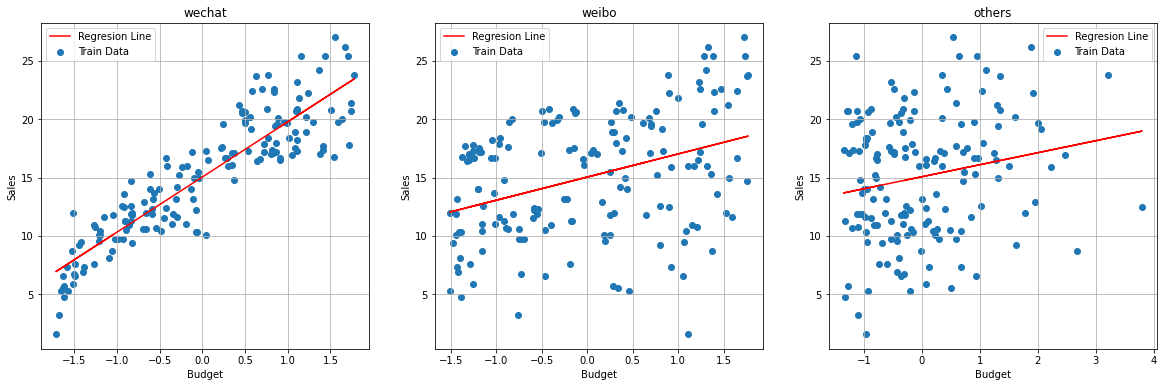

In [19]:
fig, axes = plt.subplots(1, len(X_train.columns), figsize=(20, 6))

for i in range(3):
  X_values = X_train.iloc[:,i].values.reshape(-1, 1)
  y_values = y_train.values.reshape(-1, 1)

  axes[i].scatter(transformed_train.iloc[:,i], y_values, label='Train Data')
  model = model_result[X_train.columns[i]]
  predicted = model.predict(X_values)

  axes[i].plot(transformed_train.iloc[:,i], predicted, color='red', label='Regresion Line')
  axes[i].set_title(X_train.columns[i])
  axes[i].set_xlabel('Budget')
  axes[i].set_ylabel('Sales')
  axes[i].grid()
  axes[i].legend()

Comentario:

* Se genera un gráfico con la linea de tendencia central de cada variable, de esta forma se análiza que modelo es mejor según sus datos de entrenamiento.

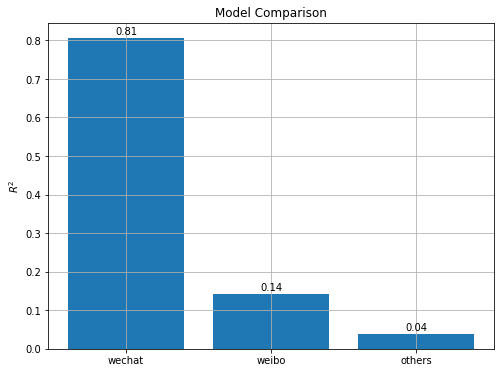

In [21]:
scores = []
for i, feature in enumerate(X_train.columns):
  X_values = X_train.iloc[:,i].values.reshape(-1, 1)
  y_values = y_train.values.reshape(-1, 1)
  model = model_result[feature]
  scores.append(model.score(X_values, y_values))

plt.figure(figsize=(8,6))
plt.bar(X_train.columns, scores)
plt.ylabel('$R^2$')
plt.title('Model Comparison')
plt.grid()

def add_labels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i] + 0.01, round(y[i],2), ha = 'center')

add_labels(X_train.columns, scores)



Comentario: 
* Mediante la metrica $R^2$ se determinara el mejor modelo a usar, recordando que si el resultado de la metrica es cercano a 1, será el más confiable.

In [22]:
from itertools import combinations

all_combinatios = []
model_final = {}
features = ['wechat', 'weibo', 'others']
final_scores = []
for i in range(1, 4):
  all_combinatios += list(combinations(features, i))

all_combinatios = [list(combination) for combination in all_combinatios]
all_combinatios

[['wechat'],
 ['weibo'],
 ['others'],
 ['wechat', 'weibo'],
 ['wechat', 'others'],
 ['weibo', 'others'],
 ['wechat', 'weibo', 'others']]

Comentario:
* Con la herramienta itertools se generan las posibles combinaciones de las caracteristicas, de esta forma se podrá determinar la mejor inversión para 2 caracteristicas de la variable a predecir.

In [23]:
for combination in all_combinatios:
   sgd = SGDRegressor()
   X_values = X_train[combination].values.reshape(-1, len(combination))
   y_values = y_train.ravel()
   
   regressorSGD = Pipeline(
      steps=[("numerical_imputer", SimpleImputer(strategy='mean')), 
           ("scaler", StandardScaler()), 
           ("sgd", SGDRegressor())])
  
   regressorSGD.fit(X_values, y_values)
   y_pred = regressorSGD.predict(X_values)
   model_final[combination.__repr__()] = regressorSGD
   final_scores.append(regressorSGD.score(X_values, y_values))

[0.8057534854765929, 0.14241729377673362, 0.038328547036317495, 0.9007474967289204, 0.8200045986784666, 0.1471341302179937, 0.9009641493019973]


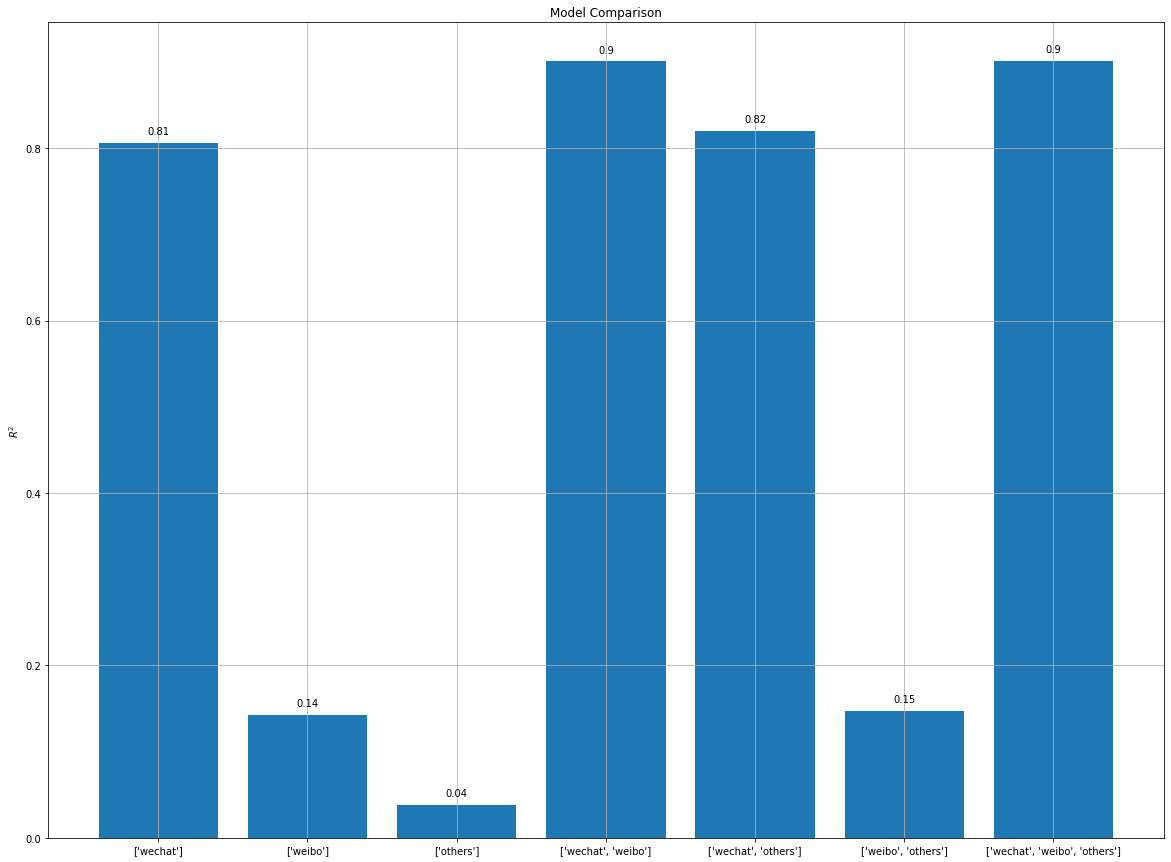

In [24]:
plt.figure(figsize=(20,15))
plt.bar(model_final.keys(), final_scores)
plt.ylabel('$R^2$')
plt.title('Model Comparison')
plt.grid()
  
def add_labels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i] + 0.01, round(y[i],2), ha = 'center')

add_labels(model_final.keys(), final_scores)  
print(final_scores)  

Comentario: 

* Se aprecia que principalmente invertir en Wechat sale como una ganancia en la publicidad ya que su score es bastante alto individualmente. No obstante, si se invierte en Wechat y Weibo, el score aumenta hasta 0.9 lo que da a entender que tambien es una buena opción de inversión públicitaria.

## __Evaluación de desempeño__

In [25]:
test_scores = []

X_test, y_test = test.drop('sales', axis='columns'), test['sales']

for combination in all_combinatios:

  X_values = X_test[combination].values.reshape(-1,len(combination))
  y_values = y_test.values.reshape(-1, 1)

  model = model_final[combination.__repr__()]
  test_scores.append(model.score(X_values, y_values))


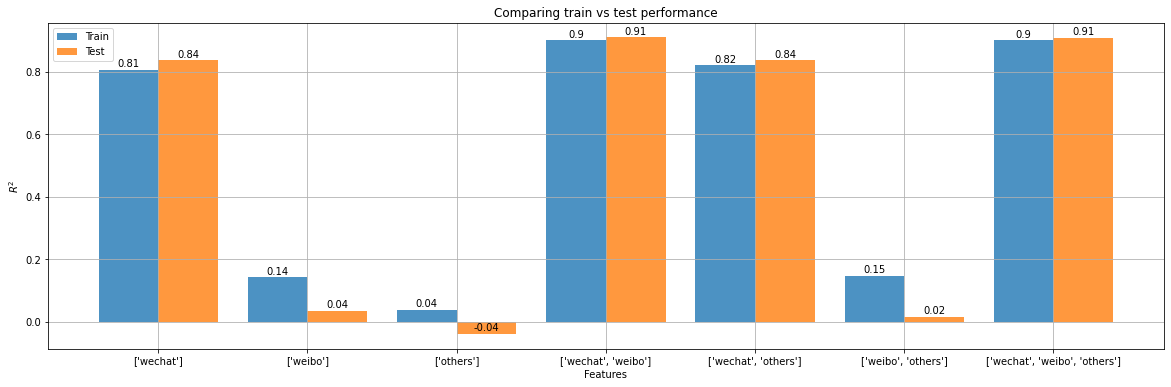

In [26]:
plt.figure(figsize=(20,6))

X_axis = np.arange(len(model_final.keys()))

plt.bar(X_axis - 0.2, final_scores, 0.4, label = 'Train', alpha=0.8)
plt.bar(X_axis + 0.2,test_scores, 0.4, label = 'Test', alpha=0.8)

plt.ylabel('$R^2$')
plt.title('Test Comparison')
plt.grid()
plt.xticks(X_axis, model_final.keys())
plt.xlabel("Features")
plt.title("Comparing train vs test performance")
plt.legend()
  
def addlabels(x, y, val):
    for i in range(len(x)):
        plt.text(i + val , y[i] + 0.01, round(y[i],2), ha = 'center')

addlabels(model_final.keys(), final_scores, - 0.2)
addlabels(model_final.keys(), test_scores, + 0.2)
plt.show()

Compare los coeficientes de determinación de los datos de prueba con lo obtenidos en los datos de entrenamiento a través de un gráfico de barras

Comentario: 
* Se concluye mediante la métrica $R^2$ que el modelo planteado para Wechat es altamente confiable debido a su resultado, por ende la empresa deberia de invertir en Wechat para públicidad.
* Por otro lado, se aprecia que el modelo se ajusta muy bien a los datos proporcionados por el dataset.
* La empresa cuenta con una segunda opción de inversión que es Wwchat y Weibo, ya que estas dos juntas arrojan muy buenos resultados en su Score.